# Quantum Characterisation, Verification and Validation

To demonstrate how to implement new benchmarking experiments within the Superstaq QCVV framework,
consider implementing a naive benchmarking routine where we try to estimate the fidelity of a single
qubit Z gate by repeatedly applying the gate to a qubit in the ground state (such that the Z-gate
should have no effect) and observing if any observations of the excited state occur. If the excited 
state is observed this indicates an error has occurred. Assuming that each time the Z-gate is
applied the probability of a bit flip error is $e$ then after $d$ gates the probability of 
observing the ground state is $$p(0) = \frac{1}{2}(1-e)^d + \frac{1}{2}$$

We can create an experiment to measure this as follows

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import annotations

In [2]:
from supermarq.qcvv.base_experiment import BenchmarkingExperiment, Sample, QCVVResults
from dataclasses import dataclass
from collections.abc import Sequence
from typing import Iterable
from tqdm.contrib.itertools import product
import pandas as pd

import cirq

from scipy.stats import linregress
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


@dataclass(frozen=True)
class NaiveExperimentResult(QCVVResults):
    gate_fidelity: float
    gate_error: float


class NaiveExperiment(BenchmarkingExperiment):
    def __init__(self):
        super().__init__(num_qubits=1)

    def build_circuits(self, num_circuits: int, layers: Iterable[int]) -> Sequence[Sample]:
        """Build the circuits by composing multiple Z gates together into circuits. The
        number of gates to compose is given by the `layers` parameter.
        """
        samples = []
        for _, depth in product(range(num_circuits), layers, desc="Building circuits."):
            circuit = cirq.Circuit([cirq.Z(*self.qubits) for _ in range(depth)])
            circuit += cirq.measure(*self.qubits)
            samples.append(Sample(circuit=circuit, data={"depth": depth}))

        return samples

    def process_probabilities(self, samples) -> None:
        """Copy the data and observed probabilities into a pandas DataFrame."""
        records = []
        for sample in samples:
            records.append({**sample.data, **sample.probabilities})
        return pd.DataFrame(records)

    def analyse_results(self, plot_results: bool = True) -> NaiveExperiment:
        """To analyse the results to fit a simple exponential decay. This can be done easily
        by fitting a linear model to the logarithm of the equation above.
        """

        model = linregress(x=self.raw_data["depth"], y=np.log(2 * self.raw_data["0"] - 1))

        fidelity = np.exp(model.slope)

        self._results = NaiveExperimentResult(
            experiment_name="Naive Experiment",
            target="& ".join(self.sample_targets),
            total_circuits=len(self.samples),
            gate_fidelity=fidelity,
            gate_error=1 - fidelity,
        )

        if plot_results:
            self.plot_results()

        return self.results

    def plot_results(self) -> None:
        """Plot the data with the fit superimposed on top."""

        fig, axs = plt.subplots(
            1,
        )

        sns.scatterplot(self.raw_data, x="depth", y="0", ax=axs)

        x = np.linspace(0, max(self.raw_data.depth))
        y = 0.5 * self.results.gate_fidelity**x + 0.5
        axs.plot(x, y)
        axs.set_xlabel("Circuit depth")
        axs.set_ylabel("Probability of ground state")

To test this basic experiment, we use a depolarising noise model and a density matrix simulator.
Note that if we use a single qubit depolarising channel with pauli error rate $p$ this will result in an 
error with probability of $4p/3$.

In [3]:
noise = cirq.DepolarizingChannel(p=0.01)
simulator = cirq.DensityMatrixSimulator(noise=noise)
experiment = NaiveExperiment()
experiment.run_with_simulator(10, [10, 50, 100], shots=2000, target=simulator)

Building circuits.:   0%|          | 0/30 [00:00<?, ?it/s]

Simulating circuits:   0%|          | 0/30 [00:00<?, ?it/s]

NaiveExperimentResult(experiment_name='Naive Experiment', target='Local simulator', total_circuits=30, gate_fidelity=0.9862489774018681, gate_error=0.013751022598131879)


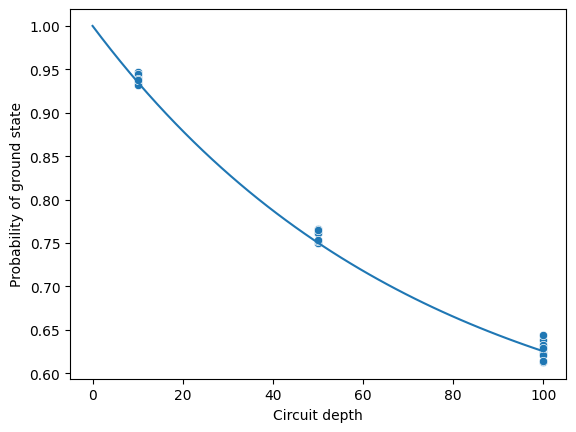

In [4]:
if experiment.collect_data():
    results = experiment.analyse_results(plot_results=True)
    print(results)

Checking this result we have

In [5]:
pauli_error_rate = 3 / 4 * experiment.results.gate_error
print(pauli_error_rate)

0.01031326694859891


Which agrees very closely with our channel which we set up with $p=0.01$

We could also run the same experiment on a device through Superstaq. In this case we use the 
`run_on_device()` method instead, although for this example we use the Superstaq simulator device. 
Note we also use the `force=True` option to overwrite our existing
results.

In [12]:
experiment_job = experiment.run_on_device(
    5, [10, 50, 100], target="ss_unconstrained_simulator", shots=1000, overwrite=True
)

Building circuits.:   0%|          | 0/15 [00:00<?, ?it/s]

Retrieving jobs:   0%|          | 0/15 [00:00<?, ?it/s]

NaiveExperimentResult(experiment_name='Naive Experiment', target='ss_unconstrained_simulator', total_circuits=15, gate_fidelity=1.0, gate_error=0.0)


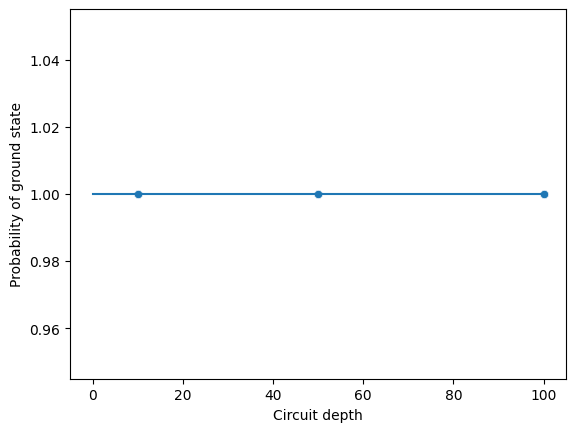

In [13]:
if experiment.collect_data():
    results = experiment.analyse_results(plot_results=True)
    print(results)

As expected, since the Superstaq simulator is exact, we obtain a gate fidelity of 1.0